# 02. Домашнее задание. Обучение Vision Transformer


В этом задании вам предлагается дописать реализацию ViT и обучить его на датасете CIFAR-10.

![](https://hashtelegraph.com/wp-content/uploads/2024/08/shooting-sparrows-with-a-cannon--1024x576.jpg)

## 1. Patch Embeddings

Отличительной особенностью ViT является эмбеддинги изображений. Чтобы представить изображение в виде входного вектора для трансформера, оно разбивается на фрагменты (patches) заданного размера. В нашей имплементации это будет сделано с помощью обучаемой свертки.

In [ ]:
import math
import torch
from torch import nn


class PatchEmbeddings(nn.Module):
    """
    Преобразуйте изображение в патчи, а затем спроецируйте их в векторное пространство.
    """
    def __init__(self, config):
        super().__init__()
        self.image_size = config["image_size"]
        self.patch_size = config["patch_size"]
        self.num_channels = config["num_channels"]
        self.hidden_size = config["hidden_size"]
        # Количество фрагментов, исходя из размера изображения и размера фрагмента.
        self.num_patches = (self.image_size // self.patch_size) ** 2
        self.projection = nn.Conv2d(
            in_channels=self.num_channels,
            out_channels=self.hidden_size,
            kernel_size=self.patch_size,
            stride=self.patch_size
        )


    def forward(self, x):
        # (batch_size, num_channels, image_size, image_size) -> (batch_size, num_patches, hidden_size)
        batch_size = x.shape[0]
        x = self.projection(x)
        x = x.flatten(2).transpose(1, 2)
        assert x.shape[0] == batch_size
        assert x.shape[1] == self.num_patches
        assert x.shape[2] == self.hidden_size
        return x

**Пояснение:**
- **in_channels:** Количество входных каналов (обычно 3 для RGB).

- **out_channels:** Размер скрытого пространства (hidden_size), в которое проецируется каждый патч.

- **kernel_size:** Размер патча (patch_size), чтобы свертка захватывала каждый патч целиком.

- **stride:** Шаг свертки равен patch_size, чтобы патчи не перекрывались.

In [2]:
class Embeddings(nn.Module):
    """
    Combine the patch embeddings with the class token and position embeddings.
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.patch_embeddings = PatchEmbeddings(config)
        # Создаем обучаемый [CLS] токен
        # Подобно BERT, токен [CLS] добавляется в начало входной последовательности.
        # Токен используется для классификации
        self.cls_token = nn.Parameter(torch.randn(1, 1, config["hidden_size"]))
        self.position_embeddings = nn.Parameter(torch.randn(1, self.patch_embeddings.num_patches + 1, config["hidden_size"]))
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        x = self.patch_embeddings(x)
        batch_size, _, _ = x.size()
        # Расширяем токен [CLS] до размера батча
        # (1, 1, hidden_size) -> (batch_size, 1, hidden_size)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        # Присоединяем токен [CLS] к началу входной последовательности.
        # Длина последовательности (num_patches + 1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.position_embeddings
        x = self.dropout(x)
        return x


## 2. Attention head

Допишите реализацию головы трансформера. Формулы подсчеты attention score можно найти в Лекции 5, посвященной трансформерам

In [ ]:
from torch.nn.functional import softmax


class AttentionHead(nn.Module):
    """
    Голова трансформера
    """
    def __init__(self, hidden_size, attention_head_size, dropout):
        super().__init__()
        self.hidden_size = hidden_size
        self.attention_head_size = attention_head_size

        self.query = nn.Linear(hidden_size, attention_head_size, bias=True)
        self.key = nn.Linear(hidden_size, attention_head_size, bias=True)
        self.value = nn.Linear(hidden_size, attention_head_size, bias=True)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x перемножается на query, key, value матрицы.
        # Результат перемножения используется для для подсчета attention output
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
       
        # Посчитаем attention_output по формуле: softmax(Q*K.T/sqrt(head_size)) * V
        # Опционально, на softmax(Q*K.T/sqrt(head_size)) можно добавить dropout

        # Вычисляем attention scores (Q*K^T / sqrt(head_size))
        attention_scores = torch.matmul(Q, K.transpose(-2, -1))  # [batch_size, seq_len, seq_len]
        attention_scores = attention_scores / (self.attention_head_size ** 0.5)

        # Применяем softmax и dropout к весам внимания
        attention_probs = torch.softmax(attention_scores, dim=-1)
        attention_probs = self.dropout(attention_probs)

        # Умножаем веса на значения (V)
        attention_output = torch.matmul(attention_probs, V)  # [batch_size, seq_len, head_size]
        return attention_output


class MultiHeadAttention(nn.Module):
    """
    Multi-head attention module
    """

    def __init__(self, config):
        super().__init__()
        self.hidden_size = config["hidden_size"]
        self.num_attention_heads = config["num_attention_heads"]
        # Размерность для одной головы
        self.attention_head_size = self.hidden_size // self.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        # Создадим несколько голов и добавьте их в self.heads
        self.heads = nn.ModuleList([])
        for _ in range(self.num_attention_heads):
          head = AttentionHead(
              self.hidden_size,
              self.attention_head_size,
              config["attention_probs_dropout_prob"]
          )
          self.heads.append(head)

        # Финальная линейная проекция
        self.output_projection = nn.Linear(self.all_head_size, self.hidden_size)
        self.output_dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        # Считаем параллельно в каждой голове, потом конкатенируем результат
        attention_outputs = [head(x) for head in self.heads]
        attention_output = torch.cat([attention_output for attention_output in attention_outputs], dim=-1)
        attention_output = self.output_projection(attention_output)
        attention_output = self.output_dropout(attention_output)
        return attention_output


**Пояснения к AttentionHead:**
1. Вычисление attention scores:
   - Q @ K.transpose(-2, -1) - матричное умножение query и key (транспонированных по последним двум измерениям)

   - Масштабирование на sqrt(head_size) для стабилизации градиентов

2. Softmax + Dropout:

   - Softmax применяется по последнему измерению (dim=-1) для нормализации весов

   - Dropout регуляризует веса внимания

3. Итоговый выход:

   - Взвешенная сумма значений V по полученным весам внимания

**Пояснения к MultiHeadAttention:**
1. Инициализация голов:

   - Создаем num_attention_heads экземпляров AttentionHead

2. Каждая голова получает:

   - hidden_size - исходную размерность

   - attention_head_size - размерность одной головы (hidden_size / num_heads)

   - dropout - параметр дропаута из конфига

In [4]:

class MLP(nn.Module):
    """
    Многослойный персептрон
    """

    def __init__(self, config):
        super().__init__()
        self.dense_1 = nn.Linear(config["hidden_size"], config["intermediate_size"])
        self.activation = nn.GELU()
        self.dense_2 = nn.Linear(config["intermediate_size"], config["hidden_size"])
        self.dropout = nn.Dropout(config["hidden_dropout_prob"])

    def forward(self, x):
        x = self.dense_1(x)
        x = self.activation(x)
        x = self.dense_2(x)
        x = self.dropout(x)
        return x


## 3. Encoder

Схема энкодера трансформера, используемого в ViT

![](https://theaisummer.com/static/aa65d942973255da238052d8cdfa4fcd/7d4ec/the-transformer-block-vit.png)


In [ ]:
class Block(nn.Module):
    """
    Блок энкодера, как на рисунке сверху
    """

    def __init__(self, config):
        super().__init__()
        self.attention = MultiHeadAttention(config)
        self.layernorm_1 = nn.LayerNorm(config["hidden_size"])
        self.mlp = MLP(config)
        self.layernorm_2 = nn.LayerNorm(config["hidden_size"])

    def forward(self, x):
        # x должен пройти по последовательности LayerNorm, MultiHeadAttention и
        # MLP слоев, как на рисунке сверху

        # Первый sub-layer: LayerNorm + MultiHeadAttention
        attention_output = self.attention(self.layernorm_1(x))
        x = x + attention_output

        # Второй sub-layer: LayerNorm + MLP
        mlp_output = self.mlp(self.layernorm_2(x))
        x = x + mlp_output
        return x

class Encoder(nn.Module):
    """
    Энкодер, состоящий из config["num_blocks"] блоков
    """

    def __init__(self, config):
        super().__init__()
        self.blocks = nn.ModuleList([])

        # Создадим список из config["num_blocks"] Block-ов
        for _ in range(config["num_blocks"]):
          block = Block(config)
          self.blocks.append(block)

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x


**Пояснения к Block:**

Последовательность операций:

   - Нормализация → Multi-head Attention

   - Нормализация → MLP

**Пояснения к Encoder:**

   - Состоит из стека идентичных блоков (num_blocks штук)

   - Каждый блок обрабатывает последовательность независимо

   - Вход последовательно проходит через все блоки

In [6]:
class ViTForClassfication(nn.Module):
    """
    Vision transformer. Состоит из PatchEmbedder-а, энкодера и линейного слоя
    """

    def __init__(self, config):
        super().__init__()
        self.config = config
        # 32 для CIFAR
        self.image_size = config["image_size"]
        self.hidden_size = config["hidden_size"]
        # 10 для CIFAR
        self.num_classes = config["num_classes"]

        self.embedding = Embeddings(config)
        self.encoder = Encoder(config)
        self.classifier = nn.Linear(self.hidden_size, self.num_classes)

    def forward(self, x):
        embedding_output = self.embedding(x)
        encoder_output = self.encoder(embedding_output)
        # Рассчываем логиты как выходные данные токена [CLS]
        logits = self.classifier(encoder_output[:, 0, :])

        return logits

## 4. Подготовка датасета

Эта часть мало чем отличается от Lab_3, поэтому можете свериться с ней

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms


def prepare_data(batch_size=4, num_workers=2, train_sample_size=None, test_sample_size=None):

    train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),  # Явное указание размера (хотя CIFAR-10 уже 32x32)
        transforms.RandomHorizontalFlip(),  # Случайное горизонтальное отражение
        transforms.RandomRotation(10),  # Случайный поворот на ±10 градусов
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Изменение цветов
        transforms.RandomAffine(degrees=0, shear=10, scale=(0.8,1.2)),  # Случайный сдвиг
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=train_transform)
    if train_sample_size is not None:
        # Randomly sample a subset of the training set
        indices = torch.randperm(len(trainset))[:train_sample_size]
        trainset = torch.utils.data.Subset(trainset, indices)



    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=num_workers)

    test_transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=test_transform)
    if test_sample_size is not None:
        indices = torch.randperm(len(testset))[:test_sample_size]
        testset = torch.utils.data.Subset(testset, indices)

    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=num_workers)

    return trainloader, testloader

# Finally, обучение!

Epoch: 1, Train loss: 1.8606, Test loss: 1.6178, Accuracy: 0.4004
Epoch: 2, Train loss: 1.6123, Test loss: 1.5311, Accuracy: 0.4431
Epoch: 3, Train loss: 1.5404, Test loss: 1.4032, Accuracy: 0.4819
Epoch: 4, Train loss: 1.4694, Test loss: 1.4254, Accuracy: 0.4725
Epoch: 5, Train loss: 1.4448, Test loss: 1.3421, Accuracy: 0.5112
Epoch: 6, Train loss: 1.4052, Test loss: 1.2844, Accuracy: 0.5306
Epoch: 7, Train loss: 1.3733, Test loss: 1.2729, Accuracy: 0.5373
Epoch: 8, Train loss: 1.3499, Test loss: 1.2927, Accuracy: 0.5322
Epoch: 9, Train loss: 1.3399, Test loss: 1.2711, Accuracy: 0.5360
Epoch: 10, Train loss: 1.3255, Test loss: 1.3236, Accuracy: 0.5288


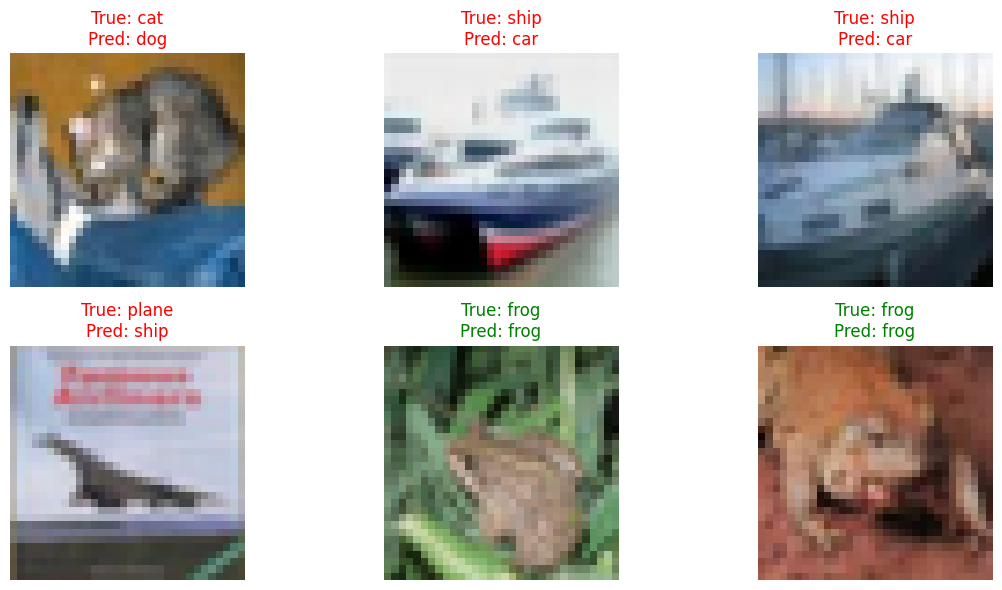

In [ ]:
batch_size = 32
epochs = 10
lr = 1e-2

import torch
from torch import nn, optim
import matplotlib.pyplot as plt
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

config = {
    "patch_size": 4,  # Input image size: 32x32 -> 8x8 patches
    "hidden_size": 48,
    "num_blocks": 4,
    "num_attention_heads": 4,
    "intermediate_size": 4 * 48, # 4 * hidden_size
    "hidden_dropout_prob": 0.0,
    "attention_probs_dropout_prob": 0.0,
    "initializer_range": 0.02,
    "image_size": 32,
    "num_classes": 10, # num_classes of CIFAR10
    "num_channels": 3,
}

assert config["hidden_size"] % config["num_attention_heads"] == 0
assert config['intermediate_size'] == 4 * config['hidden_size']
assert config['image_size'] % config['patch_size'] == 0


class Trainer:
    """
    Класс обучения
    """

    def __init__(self, model, optimizer, loss_fn, device):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.device = device

    def train(self, trainloader, testloader, epochs):
        for i in range(epochs):
            self.model.train()
            train_loss = 0
            total_samples = 0
            for batch in trainloader:
                # Move the batch to the device
                batch = [t.to(self.device) for t in batch]
                images, labels = batch
                # Zero the gradients
                self.optimizer.zero_grad()
                # Calculate the loss
                loss = self.loss_fn(self.model(images), labels)
                # Backpropagate the loss
                loss.backward()
                # Update the model's parameters
                self.optimizer.step()
                train_loss += loss.item() * len(images) # Здесь изначально была опечатка и стоял total_loss, а счетчик у нас train_loss
                total_samples += images.size(0) # Добавил для правильного вычисления среднего значения потерь

            avg_train_loss = train_loss / total_samples # Вычисляем средние потери за эпоху
            accuracy, test_loss = self.evaluate(testloader)
            print(f"Epoch: {i+1}, Train loss: {avg_train_loss:.4f}, Test loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")

    @torch.no_grad()
    def evaluate(self, testloader):
        self.model.eval()
        total_loss = 0
        correct = 0
        with torch.no_grad():
            for batch in testloader:
                # Move the batch to the device
                batch = [t.to(self.device) for t in batch]
                images, labels = batch

                # Get predictions
                logits = self.model(images)

                # Calculate the loss
                loss = self.loss_fn(logits, labels)
                total_loss += loss.item() * len(images)

                # Calculate the accuracy
                predictions = torch.argmax(logits, dim=1)
                correct += torch.sum(predictions == labels).item()
        accuracy = correct / len(testloader.dataset)
        avg_loss = total_loss / len(testloader.dataset)
        return accuracy, avg_loss

# Добавил функцию для визуализации предиктов
def show_predictions(model, testloader, device, num_images=6):
    classes = ('plane', 'car', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck')

    model.eval()
    images, labels = next(iter(testloader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    images = images.cpu()

    plt.figure(figsize=(12, 6))
    for i in range(min(num_images, len(images))):
        plt.subplot(2, 3, i+1)
        img = images[i] / 2 + 0.5  # Денормализация
        plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))

        true_label = classes[labels[i]]
        pred_label = classes[predicted[i]]
        color = 'green' if true_label == pred_label else 'red'

        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def main():
    # Training parameters
    # Load the CIFAR10 dataset
    trainloader, testloader = prepare_data(batch_size=batch_size)
    # Create the model, optimizer, loss function and trainer
    model = ViTForClassfication(config)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
    loss_fn = nn.CrossEntropyLoss()
    trainer = Trainer(model, optimizer, loss_fn, device=device)
    trainer.train(trainloader, testloader, epochs)
    # Показать несколько примеров с предсказаниями
    show_predictions(model, testloader, device)


if __name__ == '__main__':
    main()


Epoch: 1, Train loss: 2.6073, Test loss: 2.0232, Accuracy: 0.2491
Epoch: 2, Train loss: 1.9639, Test loss: 1.7566, Accuracy: 0.3394
Epoch: 3, Train loss: 86.8836, Test loss: 5.2677, Accuracy: 0.1543
Epoch: 4, Train loss: 3.0443, Test loss: 2.4512, Accuracy: 0.2435
Epoch: 5, Train loss: 2.1022, Test loss: 2.1141, Accuracy: 0.2658
Epoch: 6, Train loss: 1.8907, Test loss: 1.7240, Accuracy: 0.3544
Epoch: 7, Train loss: 1.7168, Test loss: 1.5728, Accuracy: 0.4256
Epoch: 8, Train loss: 1.5821, Test loss: 1.5238, Accuracy: 0.4257
Epoch: 9, Train loss: 1.5561, Test loss: 1.5605, Accuracy: 0.4338
Epoch: 10, Train loss: 1.5511, Test loss: 1.5200, Accuracy: 0.4583
Epoch: 11, Train loss: 1.5541, Test loss: 1.4946, Accuracy: 0.4630
Epoch: 12, Train loss: 67.6965, Test loss: 2.5437, Accuracy: 0.2160
Epoch: 13, Train loss: 2.3268, Test loss: 1.9903, Accuracy: 0.2728
Epoch: 14, Train loss: 1.9211, Test loss: 1.7080, Accuracy: 0.3732
Epoch: 15, Train loss: 1.7519, Test loss: 1.6586, Accuracy: 0.4088
Ep

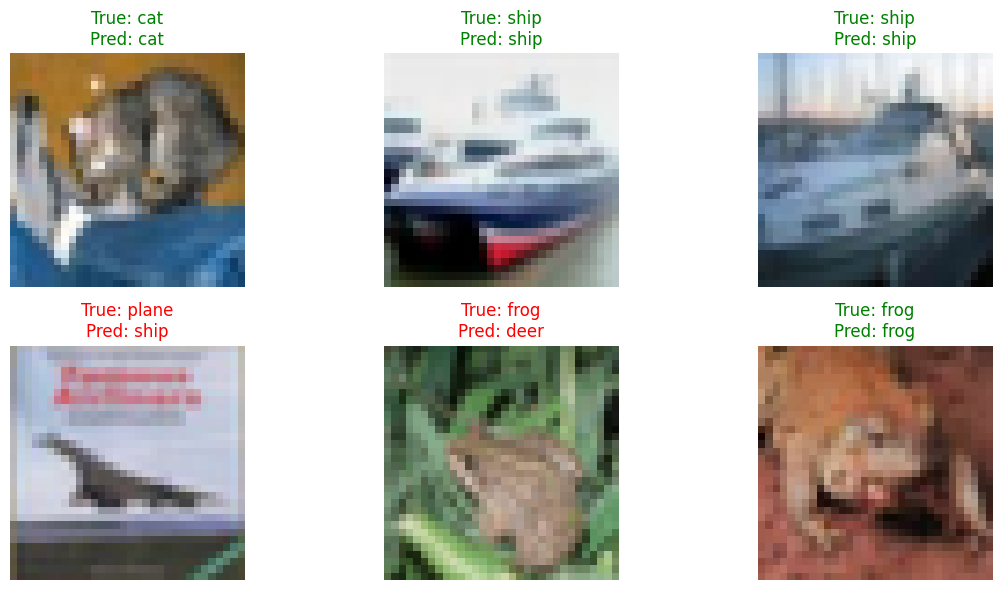

In [ ]:
# С измененными конфигами, для облегчения просто скопировал код
batch_size = 32
epochs = 20
lr = 1e-2

import torch
from torch import nn, optim
import matplotlib.pyplot as plt
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

config = {
    "patch_size": 4,  # Input image size: 32x32 -> 8x8 patches
    "hidden_size": 128,
    "num_blocks": 8,
    "num_attention_heads": 4,
    "intermediate_size": 4 * 128, # 4 * hidden_size
    "hidden_dropout_prob": 0.0,
    "attention_probs_dropout_prob": 0.0,
    "initializer_range": 0.02,
    "image_size": 32,
    "num_classes": 10, # num_classes of CIFAR10
    "num_channels": 3,
}

assert config["hidden_size"] % config["num_attention_heads"] == 0
assert config['intermediate_size'] == 4 * config['hidden_size']
assert config['image_size'] % config['patch_size'] == 0


class Trainer:
    """
    Класс обучения
    """

    def __init__(self, model, optimizer, loss_fn, device):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.device = device

    def train(self, trainloader, testloader, epochs):
        for i in range(epochs):
            self.model.train()
            train_loss = 0
            total_samples = 0
            for batch in trainloader:
                # Move the batch to the device
                batch = [t.to(self.device) for t in batch]
                images, labels = batch
                # Zero the gradients
                self.optimizer.zero_grad()
                # Calculate the loss
                loss = self.loss_fn(self.model(images), labels)
                # Backpropagate the loss
                loss.backward()
                # Update the model's parameters
                self.optimizer.step()
                train_loss += loss.item() * len(images) # Здесь изначально была опечатка и стоял total_loss, а счетчик у нас train_loss
                total_samples += images.size(0) # Добавил для правильного вычисления среднего значения потерь

            avg_train_loss = train_loss / total_samples # Вычисляем средние потери за эпоху
            accuracy, test_loss = self.evaluate(testloader)
            print(f"Epoch: {i+1}, Train loss: {avg_train_loss:.4f}, Test loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")

    @torch.no_grad()
    def evaluate(self, testloader):
        self.model.eval()
        total_loss = 0
        correct = 0
        with torch.no_grad():
            for batch in testloader:
                # Move the batch to the device
                batch = [t.to(self.device) for t in batch]
                images, labels = batch

                # Get predictions
                logits = self.model(images)

                # Calculate the loss
                loss = self.loss_fn(logits, labels)
                total_loss += loss.item() * len(images)

                # Calculate the accuracy
                predictions = torch.argmax(logits, dim=1)
                correct += torch.sum(predictions == labels).item()
        accuracy = correct / len(testloader.dataset)
        avg_loss = total_loss / len(testloader.dataset)
        return accuracy, avg_loss

# Добавил функцию для визуализации предиктов
def show_predictions(model, testloader, device, num_images=6):
    classes = ('plane', 'car', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck')

    model.eval()
    images, labels = next(iter(testloader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    images = images.cpu()

    plt.figure(figsize=(12, 6))
    for i in range(min(num_images, len(images))):
        plt.subplot(2, 3, i+1)
        img = images[i] / 2 + 0.5  # Денормализация
        plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))

        true_label = classes[labels[i]]
        pred_label = classes[predicted[i]]
        color = 'green' if true_label == pred_label else 'red'

        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def main():
    # Training parameters
    # Load the CIFAR10 dataset
    trainloader, testloader = prepare_data(batch_size=batch_size)
    # Create the model, optimizer, loss function and trainer
    model = ViTForClassfication(config)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
    loss_fn = nn.CrossEntropyLoss()
    trainer = Trainer(model, optimizer, loss_fn, device=device)
    trainer.train(trainloader, testloader, epochs)
    # Показать несколько примеров с предсказаниями
    show_predictions(model, testloader, device)


if __name__ == '__main__':
    main()


Для улучшения метрики Accuracy, возможно, необходимо увеличить количество эпох.